## Entropy experiment

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import numpy as np
import os
import time
from random import randint

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# hidden_state = torch.load('/home/fuchiang137/LLM_infer/trt_LLM/alpaca-lora/hidden_state_dump/hidden_states_layer_14.pt')
hidden_state = torch.randn(4, 45, 50)

In [16]:
print(hidden_state.shape)

torch.Size([4, 45, 50])


In [17]:
def entropy(x):
    x = x.clone().to(dtype=torch.float64)
    max_x = torch.max(x, dim=2, keepdim=True).values
    
    exp_x_sub_max = torch.exp(x - max_x)
    A = torch.sum(exp_x_sub_max, dim=2, keepdim=True)    # sum of exp(x_i)
    
    B = torch.sum(x * exp_x_sub_max, dim=2, keepdim=True)  # sum of x_i * exp(x_i)

    return (torch.log(A) - max_x - B/A).squeeze()

In [18]:
entropy(hidden_state)

tensor([[-1.8750,  0.0711, -0.5486, -1.6848, -0.3124, -1.2559, -0.8807, -1.1593,
         -0.5878, -1.0897, -0.8477, -1.7443,  0.2216, -1.0942, -0.2106, -0.3221,
         -0.0839, -1.0593, -0.5189, -1.3061, -1.3074, -2.5563, -2.1899, -2.1368,
         -0.8703, -2.1131, -0.6357,  0.0977, -3.1046, -2.2922, -1.8377, -1.6243,
         -1.2353, -0.4391, -1.5732, -5.0767,  0.3452, -1.0922, -1.5361, -2.2458,
         -0.5368,  1.3741, -0.5819, -0.1792, -1.3125],
        [-2.1603, -0.4987,  0.5219, -1.2460, -0.3670, -2.4701, -0.5145, -1.1384,
         -0.8606, -1.7031, -2.5134, -0.5597, -1.0266, -0.1468, -0.7492, -2.7322,
         -0.8382, -0.2936, -2.2243,  0.9047, -0.2684, -0.7805, -0.3642, -2.5276,
         -1.2318, -0.3886,  0.5313, -1.2534, -0.7936, -1.6719, -1.2316, -1.3455,
          0.2915, -2.3420, -0.2910, -0.3082, -2.6680, -0.2373,  0.2128,  0.8257,
         -0.7295, -0.1020, -1.9769, -1.2864, -2.9926],
        [-0.9100,  0.3411,  0.0820, -1.8572, -2.8789, -2.3912, -1.7199, -1.0454,

## Print entropy heatmap

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl
import csv

In [3]:
num_layer = 32
num_token = 84
which_beam = 0

layers = list(range(num_layer))
tokens = list(range(num_token))

In [4]:
# x is a tokens * layers tensor
x = torch.tensor([]).to('cuda:0')
for token in tokens:
    temp_x = torch.tensor([]).to('cuda:0')
    
    for layer in layers:
        dump_dir = f'/home/u4874056/entropy_dump/entropy_{token}_{layer}.pt'
        if not os.path.isfile(dump_dir):
            continue

        hidden_state = torch.load(dump_dir).to('cuda:0')

        if temp_x.shape == torch.Size([0]):
#             temp_x = torch.cat((temp_x, hidden_state[which_beam]), 0)
            temp_x = torch.cat((temp_x, torch.min(hidden_state, 0).values), 0)
            temp_x = temp_x[None, :]
        else:
#             temp_x = torch.cat((temp_x, hidden_state[which_beam][None, :]), 0)
            temp_x = torch.cat((temp_x, torch.min(hidden_state, 0).values[None, :]), 0)

    x = torch.cat((x, temp_x), 1)

In [5]:
print(x.shape)

torch.Size([32, 84])


In [6]:
entropy = x.cpu().numpy()[:num_layer,:num_token]

print(entropy[0][:][:])

[8.18439922 8.31620368 8.31237863 8.31353401 8.31709693 8.31547003
 8.31705076 8.31434634 8.31730923 8.30738019 8.31710733 8.31525422
 8.31730864 8.3166324  8.31724959 8.31744083 8.31712323 8.31744899
 8.3134657  8.31737406 8.31530554 8.31344872 8.31364922 8.31686342
 8.31720484 8.31695506 8.317346   8.31659485 8.31306821 8.31665231
 8.31728253 8.31729178 8.31713033 8.31714337 8.31718056 8.31721773
 8.31730967 8.31611331 8.31359207 8.31280043 8.31692675 8.31721512
 8.31728471 8.31664424 8.31332544 8.31253433 8.31686353 8.31582765
 8.31675233 8.31632354 8.31693923 8.31708571 8.31680147 8.31683993
 8.31682745 8.31713267 8.31678422 8.31564621 8.31706959 8.31567282
 8.31706566 8.31696586 8.31673583 8.31699075 8.31577466 8.31655311
 8.31574553 8.31712582 8.31701793 8.31708366 8.31707305 8.31578344
 8.31713371 8.31594955 8.31715885 8.31712321 8.3160768  8.31627217
 8.31693453 8.31730424 8.3166487  8.31545067 8.31714415 8.31587801]


In [7]:
entropy = x.cpu().numpy()[:num_layer,:num_token]

# sphinx_gallery_thumbnail_number = 2
plt.figure(figsize=(10,6))


with open('output.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    writer.writerow(['layer'] + tokens[:])
    
    for i in layers:
        writer.writerow([f'{i}'] + list(entropy[i]))

<Figure size 1000x600 with 0 Axes>

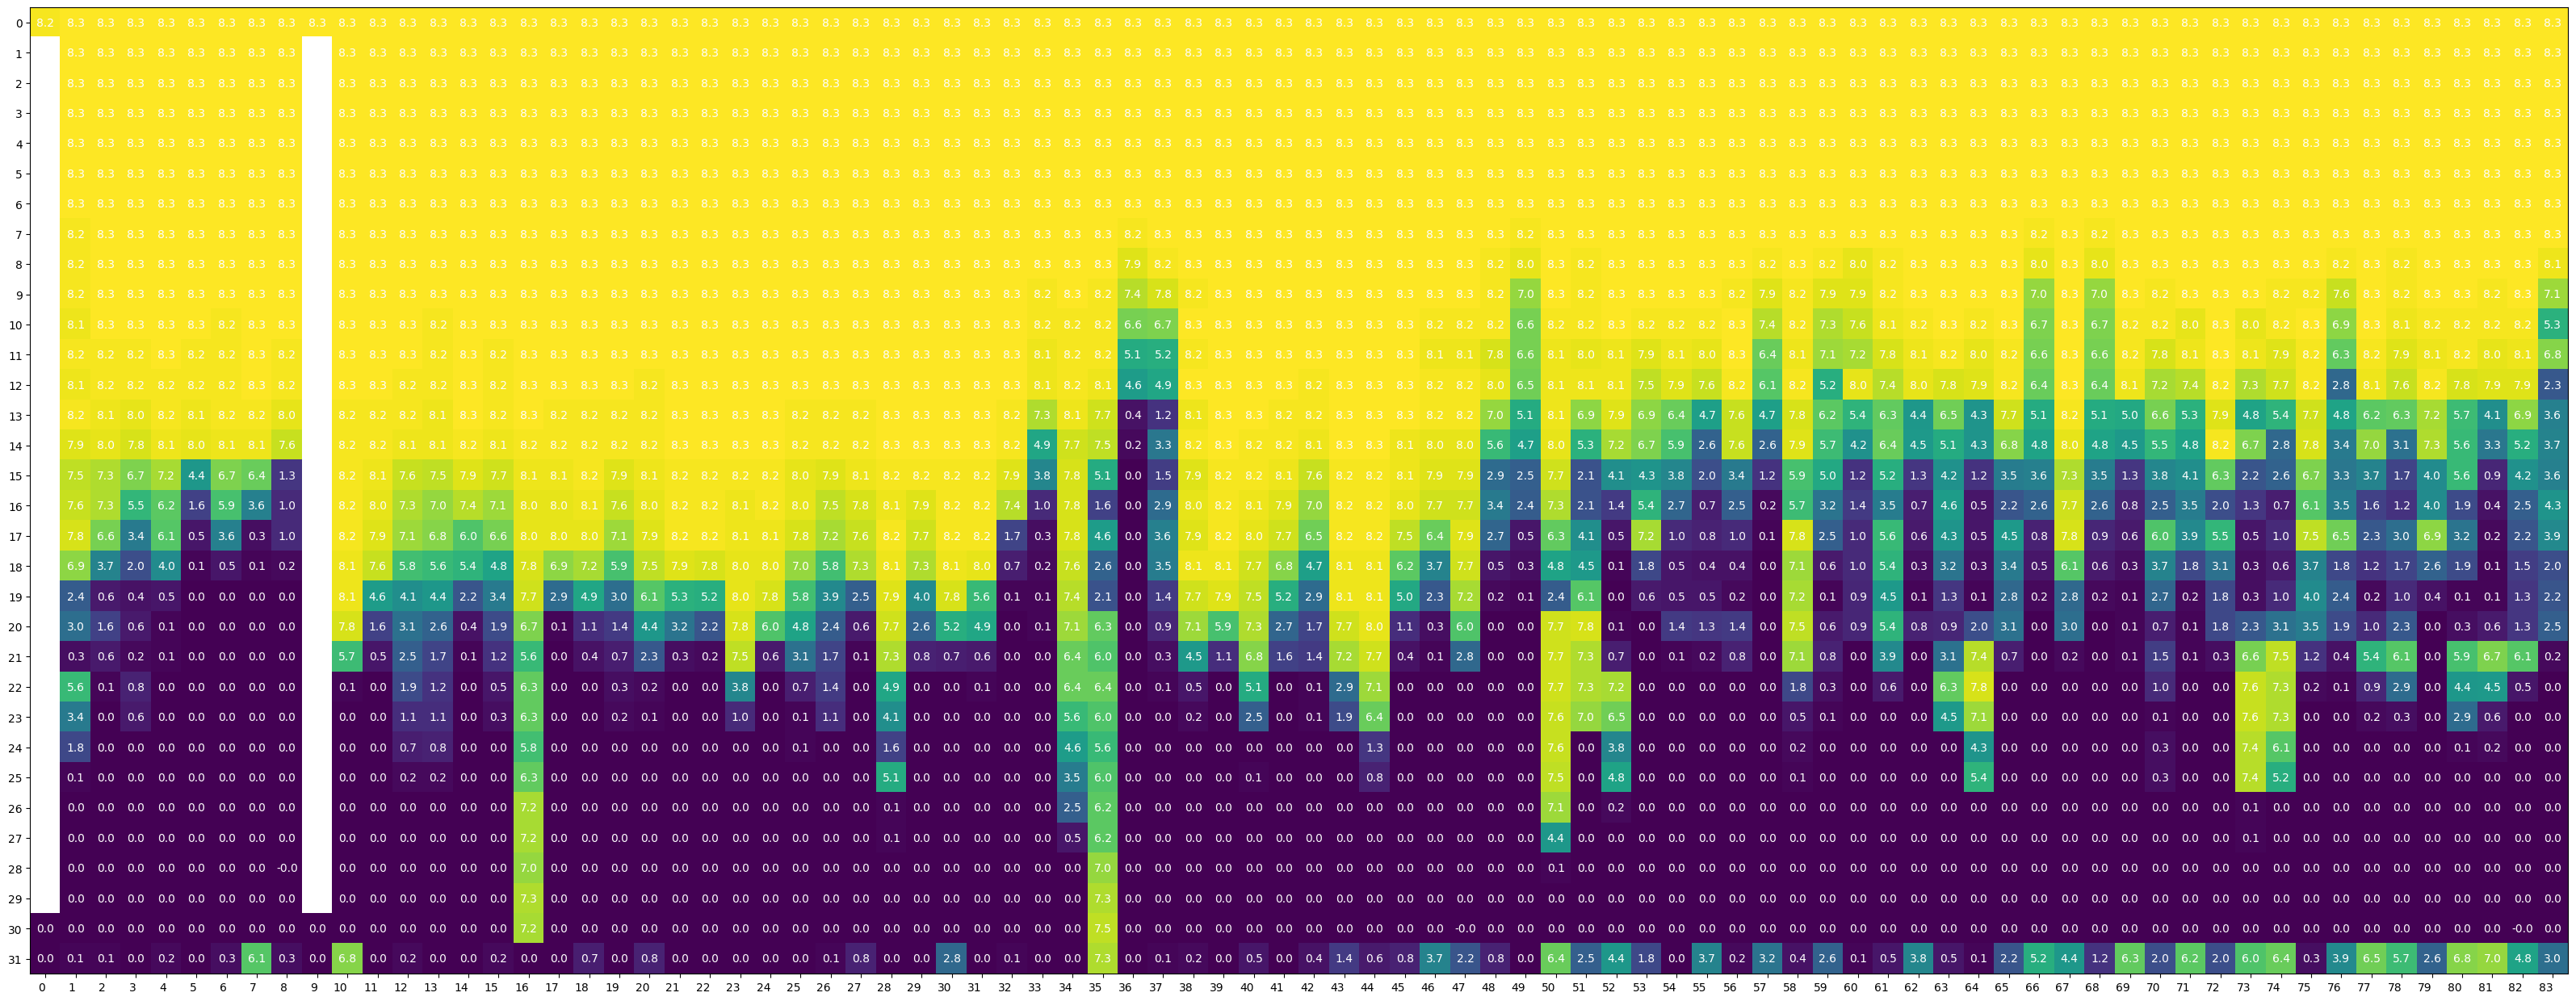

In [8]:
entropy = np.round(entropy, 1)


fig, ax = plt.subplots(1, figsize=(num_layer, num_token))
im = ax.imshow(entropy)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(tokens)), labels=tokens)
ax.set_yticks(np.arange(len(layers)), labels=layers)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in layers:
    for j in tokens:
        text = ax.text(j, i, entropy[i, j],
                       ha="center", va="center", color="w")

# ax.set_title("Harvest of local farmers (in tons/year)")

fig.tight_layout()
plt.show()

In [12]:
print((x[:,21]))

tensor([8.3141e+00, 3.0268e-01,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,        nan,
        0.0000e+00, 1.3287e-12], device='cuda:0', dtype=torch.float64)
